# Demonstrate the effect of spectral matching to color measurement results


In [1]:
import pandas as pd
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from luxpy import _CMF, plot_spectrum_colors
from luxpy.color.utils import plot_cmfs, plot_color_data
from luxpy.toolboxes.photbiochem import _BLH, Km_correction_factor
from luxpy.toolboxes.photbiochem import _ACTIONSPECTRA_CIES026
from luxpy.toolboxes.indvcmf import add_to_cmf_dict
from luxpy.spectrum import spd_to_xyz
from luxpy.toolboxes.spdbuild import mono_led_spd
from empir19nrm02.tools.plotting import get_data_step, confidence_ellipse
from empir19nrm02.MC import MCVectorVar, NameUnit, load_from_excel_raw



from empir19nrm02 import _SPD, _RES
from empir19nrm02.tools.help import display_color_diagram, display_spectra

print('Version of luxpy:', lx.__version__)
out_dir = 'ColorDemo'

import os
print( 'CWD:', os.getcwd())

marker = ['-', '--', '-.',':']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']

def new_dir( out_dir, new_dir):
    out_dir2 = out_dir + '/' + new_dir
    if not os.path.isdir(out_dir2):
            os.mkdir( out_dir2)
    return out_dir2


Version of luxpy: v1.10.0
CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


## Select some settings for the processing

In [2]:
# Calibration illuminant
S_C = 'A'
S_C = 'L41'
print( 'Calibration with: ', S_C)

# Select the color space for evaluation
cieobs = '1931_2'
print('Color matching functions from:', cieobs)

# display the colorbar in some diagrams
spectrum_color = True

#select the wavelength range for evaluation (with model LEDs)
wl_check = np.arange(405, 700+1, 5)

#define the wavelength scale for the calculation
wl_calc = lx.getwlr([380,780,1])

Calibration with:  L41
Color matching functions from: 1931_2


# Use SPD data base with MONOLED and PHOTOLED for further evaluation
What is included here?
* Show name
* Plot selected SD
* plot the color values in a color diagram

SPD data base:
Name: BB 			 Size: 55
Name: PTLED 			 Size: 229
Name: CIES025_PTLED 			 Size: 228
Name: OSRAM_PTLED 			 Size: 137
Name: RGBLED 			 Size: 98
Name: CIES025_RGBLED 			 Size: 97
Name: PHOTOLED 			 Size: 1496


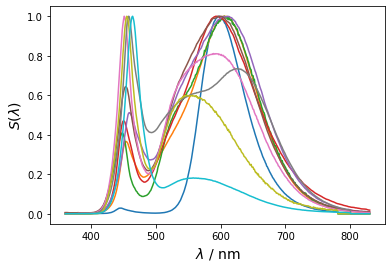

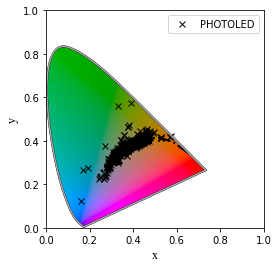

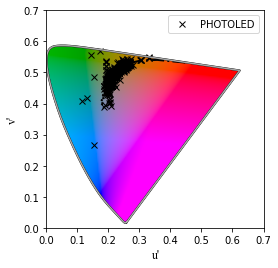

Name: TC2_90 			 Size: 1300
Name: MONOLED 			 Size: 638


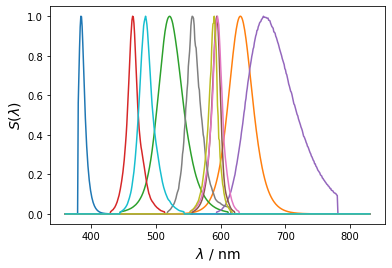

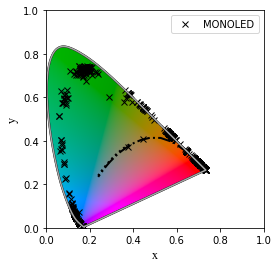

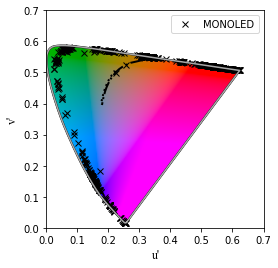

Name: OSRAM_MONOLED 			 Size: 260


In [3]:
print('SPD data base:')
for spd, enable  in _SPD.items():
    print('Name:', spd, '\t\t\t', 'Size:', _SPD[spd]['S']['data'].shape[0]-1)
    _spectra=_SPD[spd]['S']['data'].copy()
    if spd == 'MONOLED' or spd == 'PHOTOLED':
        display_spectra( spd, _spectra, curvenumber=10)
        save_fig(out_dir, spd + '_spectra')

        display_color_diagram(spd, _spectra,cspace='Yxy', diagram_colors = True)
        save_fig(out_dir, spd + '_xy')


        display_color_diagram(spd, _spectra,cspace='Yuv76', diagram_colors = True)
        save_fig(out_dir, spd + '_uv76')

# Calibration with Standard light sources

In [4]:
#tolerance setting (in Yxy) for the standard display measurements
dtolerance = 0.005
# increasing the MU by a factor for diagrams only
k_display = 1.

In [5]:
def plot_2D(inVec:MCVectorVar, number:int=100, name:str=None, marker_color:str='r', ax1:pyplot.axes=None, center_data:bool=False):
    """
    show 2D measurement data in a diagram with  .

    Args:
        :inVec:
            | result of a MCSimulation with data to be displayed
        :number:
            | number of points to be selected for display
            | if number == 0, there is no display of the data points itself
        :name:
            | name of the data, if None the name from the MCS is used
        :marker_color:
            | color for the marker in the diagram
        :ax1:
            | diagram to be continued, if None a new one is generated
        :center_data:
            | False, display the data as they are, True: put the mean value in the centre

    Returns:
        :returns:
            | axis for further operations

    Note:
        Attention: no error management
    """
    if not ax1:
        _, ax1 = pyplot.subplots()
    if not name:
        name = inVec.name.name
    data_x = inVec.val[:, 0].copy()
    data_y = inVec.val[:, 1].copy()
    if center_data:
        data_x = data_x - np.mean(data_x)
        data_y = data_y - np.mean(data_y)
    # display the mean value
    ax1.plot([np.mean(data_x)], [np.mean(data_y)], marker_color + 'o', label=name, markersize=10)
    if number:
        _, step = get_data_step(len(data_x), number)
        ax1.plot(data_x[::step], data_y[::step], marker_color + 'x')
    confidence_ellipse(data_x, data_y, ax1, n_std=k_display*2.45, edgecolor=marker_color, linewidth=2)
    ax1.grid(visible=True)
    ax1.legend()
    if center_data:
        ax1.set_xlabel(r'$x-\bar{x}$', fontsize=label_font_size)
        ax1.set_ylabel(r'$y-\bar{y}$', fontsize=label_font_size)
    else:
        ax1.set_xlabel(r'$x$', fontsize=label_font_size)
        ax1.set_ylabel(r'$y$', fontsize=label_font_size)

    ax1.set_aspect('equal')
    return ax1


## play a little with the geometry of tolerance and acceptance intervals

In [6]:
from shapely import geometry

x0 = 1/3
y0 = 1/3

p1 = geometry.Point(dtolerance, dtolerance)
p2 = geometry.Point(dtolerance, -dtolerance)
p3 = geometry.Point(-dtolerance, -dtolerance)
p4 = geometry.Point(-dtolerance, dtolerance)

pointList = [p1, p2, p3, p4]
poly = geometry.Polygon([[p.x, p.y] for p in pointList])

p1 = geometry.Point(dtolerance+x0, dtolerance+y0)
p2 = geometry.Point(dtolerance+x0, -dtolerance+y0)
p3 = geometry.Point(-dtolerance+x0, -dtolerance+y0)
p4 = geometry.Point(-dtolerance+x0, dtolerance+y0)

pointListAbs = [p1, p2, p3, p4]
print ( pointListAbs)
polyAbs = geometry.Polygon([[p.x, p.y] for p in pointListAbs])

[<POINT (0.338 0.338)>, <POINT (0.338 0.328)>, <POINT (0.328 0.328)>, <POINT (0.328 0.338)>]


In [7]:
# generate some random numbers from the data of light source standards
def generate(name, L, UL, x, Ux, y, Uy, corr):
    print(name, L, UL, x, Ux, y, Uy, corr)
    data = MCVectorVar(name=NameUnit(name, '1'), elements=2)
    v_mean = np.array([x, y])
    v_std = np.array([Ux / 2.45, Uy / 2.45])
    corr_matrix = np.array([[1, corr], [corr, 1]])
    data.set_vector_param(v_mean, v_std, corr=corr_matrix)
    data.generate_numbers()
    return data

In [8]:
# read a couple of L3-Data items from an XLS file
L3_dataStr, L3_data = load_from_excel_raw(out_dir + '/L3-Data.xlsx')
dfL3 = pd.DataFrame(L3_dataStr[1:], columns=L3_dataStr[0])
for column_name in L3_dataStr[0][1:]:
    dfL3[column_name] = pd.to_numeric(dfL3[column_name])

# put all the data in a smal database
L3Data = []
for i in range(1, L3_data.shape[0]):
    if not 'ND' in L3_dataStr[i][0]:
        L3Data.append(generate(L3_dataStr[i][0], L3_data[i][1], L3_data[i][2], L3_data[i][3], L3_data[i][4], L3_data[i][5],
                           L3_data[i][6], L3_data[i][7]))

LCW 9920.0 0.0097 0.4372 0.00071 0.4055 0.00061 -0.63
LUW 10770.0 0.01 0.316 0.0007 0.3317 0.0011 -0.16
LD 1787.0 0.025 0.1511 0.00053 0.0266 0.00067 -1.0
LR 4574.0 0.021 0.7021 0.00072 0.2979 0.0007 -1.0
LT 9139.0 0.013000000000000001 0.1681 0.0029 0.7319 0.00088 0.97


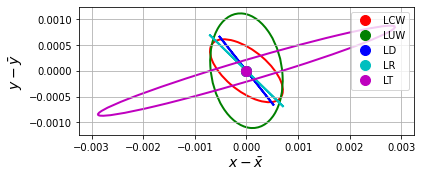

In [9]:
ax1 = None
dfL3_select = dfL3[dfL3['Name'].str.contains('ND') == False]
for i in range(len(L3Data)):
    ax1 = plot_2D(L3Data[i], number=0, ax1=ax1, marker_color=mColor[i], center_data=True)

out_L3 = new_dir( out_dir, 'L3')
save_fig(out_L3, 'L3_centred')

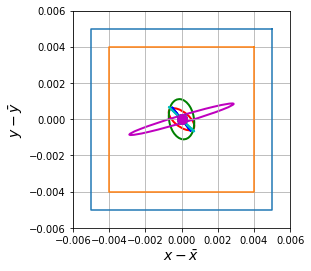

In [10]:
ax1 = None
for i in range(len(L3Data)):
    ax1 = plot_2D(L3Data[i], number=0, ax1=ax1, marker_color=mColor[i], center_data=True)

ax1.plot(*poly.exterior.xy)
eroded = poly.buffer(-0.001)
ax1.plot(*eroded.exterior.xy)
factor = 1.2
ax1.set_xlim([-factor*dtolerance, factor*dtolerance])
ax1.set_ylim([-factor*dtolerance, factor*dtolerance])
ax1.get_legend().remove()

save_fig(out_L3, 'L3_centred_tol')

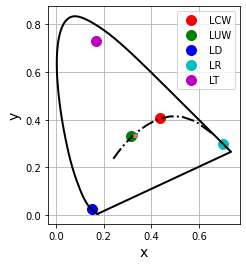

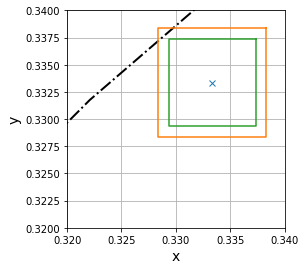

In [11]:
def L3_BB(x_lim = None, y_lim = None, use_zoom = False):
    ax1 = None
    for i in range(len(L3Data)):
        ax1 = plot_2D(L3Data[i], number=0, ax1=ax1, marker_color=mColor[i], center_data=False)

    lx.color.utils.plotSL(cieobs=cieobs, cspace='Yxy', BBL=True, axh=ax1, show=False)
    if use_zoom:
        ax1.plot(x0, y0, 'x')

    if x_lim:
        ax1.set_xlim(x_lim)
    if y_lim:
        ax1.set_ylim(y_lim)
    ax1.plot(*polyAbs.exterior.xy)
    eroded = polyAbs.buffer(-0.001)
    ax1.plot(*eroded.exterior.xy)
    if use_zoom:
        ax1.get_legend().remove()
    if x_lim:
        save_fig(out_L3, 'L3_BB' + '_zoom')
    else:
        save_fig(out_L3, 'L3_BB')

L3_BB()
L3_BB(x_lim=[0.32, 0.34], y_lim=[0.32, 0.34], use_zoom=True)

## Show the responsivities of new collections for color detectors (x,y and z) separately

* X,Y and Z Detectors
* Select the best, worst and median detector for all seperate collections
* Normalize the detectors depending on the calibration selection S_C

In [12]:
out_detector = new_dir( out_dir, 'DetectorData')

In [13]:
def get_min_max_median(f1p):
    print( 'Detector number:', len(f1p))
    iMin = np.argmin(f1p[1:])+1
    iMax = np.argmax(f1p)
    iMedian = np.argmin(np.abs(np.median(f1p) - f1p))
    print( 'Best detector: ', iMin, 'with $f_1^\prime$=', f1p[iMin])
    print( 'Worst detector: ', iMax, 'with $f_1^\prime$=', f1p[iMax])
    print( 'Median detector: ', iMedian, 'with $f_1^\prime$=', f1p[iMedian])
    return iMin, iMax, iMedian

XDetectors


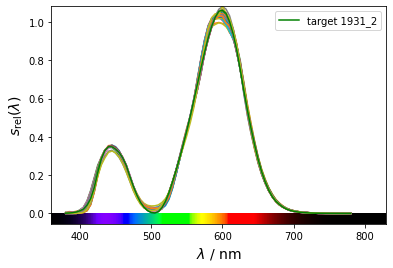

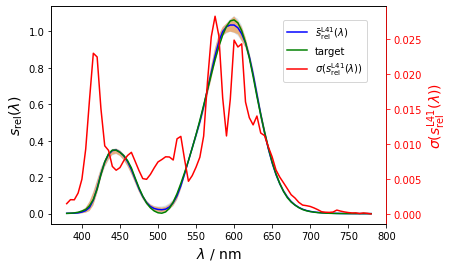

[4.0391e-07 4.6475e-02 3.6214e-02 3.8050e-02 3.7328e-02 3.9067e-02
 3.9621e-02 4.1052e-02 5.0117e-02 3.9913e-02 3.0391e-02 3.3855e-02
 4.3979e-02 3.3693e-02 3.1888e-02 3.0635e-02 3.0851e-02 2.8535e-02
 3.1285e-02 3.3651e-02 3.1627e-02 3.0915e-02 1.1936e-02 1.0980e-02
 1.0880e-02 1.1019e-02 1.0613e-02 3.2856e-02 4.6158e-02]
Detector number: 29
Best detector:  26 with $f_1^\prime$= 0.010612511971510781
Worst detector:  8 with $f_1^\prime$= 0.050116605504975105
Median detector:  27 with $f_1^\prime$= 0.032855523566943344


In [14]:
_name = 'XDetectors'
_detectors=_RES[_name]['S']['data'].copy()
XNorm, f1pX = display_responsivity(_name, _detectors, cieobs=cieobs, s_target_index=1, out_dir=out_detector, S_C=S_C, spectrum_color=spectrum_color)
collect = XNorm[1:].T
iMinX, iMaxX, iMedianX = get_min_max_median(f1pX)


YDetectors


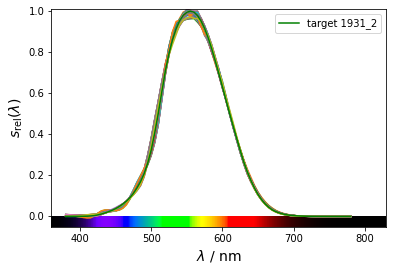

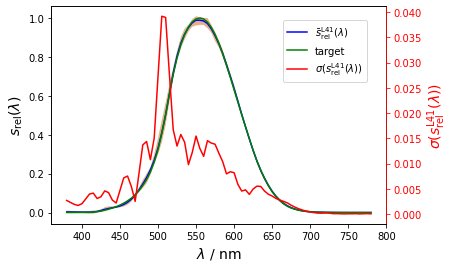

[0.0000e+00 3.2784e-02 2.2070e-02 2.1332e-02 2.1262e-02 2.5198e-02
 2.6587e-02 2.5145e-02 2.9574e-02 2.2676e-02 2.4612e-02 2.2251e-02
 3.6829e-02 3.3852e-02 3.1918e-02 3.0365e-02 3.1313e-02 3.1210e-02
 2.2501e-02 2.2689e-02 2.3784e-02 2.7327e-02 7.5231e-03 8.1952e-03
 7.4113e-03 8.3398e-03 7.9245e-03 1.4818e-02 2.8404e-02]
Detector number: 29
Best detector:  24 with $f_1^\prime$= 0.007411326248656909
Worst detector:  12 with $f_1^\prime$= 0.03682914965977278
Median detector:  20 with $f_1^\prime$= 0.023784259364672006


In [15]:
_name = 'YDetectors'
_detectors=_RES[_name]['S']['data'].copy()
YNorm, f1pY=display_responsivity(_name, _detectors, cieobs=cieobs, s_target_index=2, out_dir=out_detector, S_C=S_C, spectrum_color=spectrum_color)
collect = np.hstack((collect, YNorm[1:].T))
iMinY, iMaxY, iMedianY = get_min_max_median(f1pY)

ZDetectors


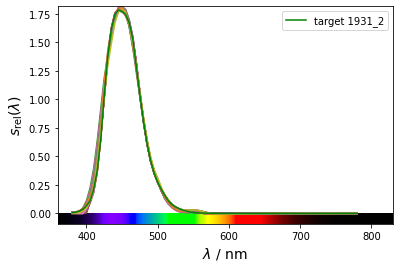

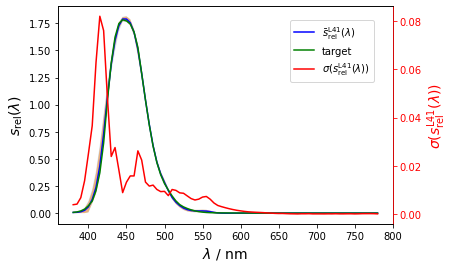

[2.4322e-12 2.7408e-02 2.4510e-02 2.4638e-02 2.7551e-02 2.1452e-02
 2.1966e-02 2.1445e-02 2.4163e-02 2.8351e-02 2.5515e-02 2.4951e-02
 7.0998e-02 6.0804e-02 6.1764e-02 5.5268e-02 5.6484e-02 5.4493e-02
 1.9811e-02 2.2649e-02 2.4050e-02 3.7207e-02 1.8671e-02 2.0420e-02
 1.9229e-02 2.1217e-02 1.7124e-02 4.1196e-02 4.8758e-02]
Detector number: 29
Best detector:  26 with $f_1^\prime$= 0.017124158170869035
Worst detector:  12 with $f_1^\prime$= 0.07099803519071256
Median detector:  3 with $f_1^\prime$= 0.024637655664657664


In [16]:
_name = 'ZDetectors'
_detectors=_RES[_name]['S']['data'].copy()
ZNorm, f1pZ = display_responsivity(_name, _detectors, cieobs=cieobs, s_target_index=3, out_dir=out_detector, S_C=S_C, spectrum_color=spectrum_color)
collect = np.hstack((collect, ZNorm[1:].T))
iMinZ, iMaxZ, iMedianZ = get_min_max_median(f1pZ)

## Select the Detector # for evaluation

In [17]:
# calc the cmf data in the same resolution as the detector has
cmfInterpolate = np.vstack((_CMF[cieobs]['bar'][0],_CMF[cieobs]['bar'][1],_CMF[cieobs]['bar'][2],_CMF[cieobs]['bar'][3]))
cmfInterpolate = lx.cie_interp(cmfInterpolate, wl_new=wl_calc, kind='S')

cmf_detector_list = list()
detector_index = list()
detector_name_list = list()

# use the ideal detector (first entry from the datasets) as reference
cmf_detector_list.append( lx.cie_interp(np.vstack((XNorm[0], XNorm[1],YNorm[1],ZNorm[1])), wl_new=wl_calc, kind='S'))
detector_index.append([0, 0, 0])
detector_name_list.append('Ideal')

# combine the cmf data of the detector
cmf_detector_list.append( lx.cie_interp(np.vstack((XNorm[0], XNorm[iMinX],YNorm[iMinY],ZNorm[iMinZ])), wl_new=wl_calc, kind='S'))
detector_index.append([iMinX, iMinY, iMinZ])
detector_name_list.append('min')

cmf_detector_list.append( lx.cie_interp(np.vstack((XNorm[0], XNorm[iMaxX],YNorm[iMaxY],ZNorm[iMaxZ])), wl_new=wl_calc, kind='S'))
detector_index.append([iMaxX, iMaxY, iMaxZ])
detector_name_list.append('max')

cmf_detector_list.append( lx.cie_interp(np.vstack((XNorm[0], XNorm[iMedianX],YNorm[iMedianY],ZNorm[iMedianZ])), wl_new=wl_calc, kind='S'))
detector_index.append([iMedianX, iMedianY, iMedianZ])
detector_name_list.append('median')

# collect all detectors in the right resolution
for i in range( 1, len(XNorm)):
    cmf_detector_list.append( lx.cie_interp(np.vstack((XNorm[0], XNorm[i],YNorm[i],ZNorm[i])), wl_new=wl_calc, kind='S'))
    detector_index.append([i, i, i])
    detector_name_list.append('#'+str(i))

# new calculation for the new arranged list
f1pX = [lx.spectral_mismatch_and_uncertainty.f1prime( np.vstack((wl_calc,cmf_detector_list[i][1])) , S_C='A', cieobs=cieobs, s_target_index=1)[0]
                                                     for i in range(len(cmf_detector_list))]
f1pY = [lx.spectral_mismatch_and_uncertainty.f1prime( np.vstack((wl_calc,cmf_detector_list[i][2])) , S_C='A', cieobs=cieobs, s_target_index=2)[0]
                                                     for i in range(len(cmf_detector_list))]
f1pZ = [lx.spectral_mismatch_and_uncertainty.f1prime( np.vstack((wl_calc,cmf_detector_list[i][3])) , S_C='A', cieobs=cieobs, s_target_index=3)[0]
                                                     for i in range(len(cmf_detector_list))]



In [18]:
# all detectors
detList = [i for i in range(len(cmf_detector_list))]
# selection for test
detList = [1,2,3, 32]

print( 'Number of evaluated detectors:', len(detList))

# Modeling for a set of FWHM settings
fwhm_list_model = [1, 10, 20, 40]

Number of evaluated detectors: 4


## Plot the CMF of the chosen standard observer

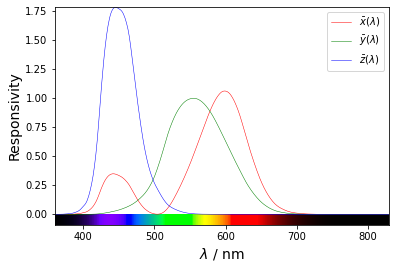

In [19]:
plot_cmf2(spectrum_color=spectrum_color)
save_fig(out_dir, 'CMF_'+cieobs)

## Plot the CMF of the chosen standard observer and the chosen detector

In [20]:
def get_f1p_str(value):
    return ' {0}={1:.1f}%'.format(strd['f1p'], value*100)

def plot_detector_cmf(i, cmf_detector, iX=None, iY=None, iZ=None, name=None, xlim=None, ylim=None, out_dir = None):
    if not name:
        name = str(i)
    if xlim or ylim:
        ax=plot_cmf2(spectrum_color=False, xlim=xlim)
    else:
        ax=plot_cmf2(spectrum_color=spectrum_color, xlim=xlim)
    if not iX:
        iX = detector_index[i][0]
    if not iZ:
        iZ = detector_index[i][1]
    if not iY:
        iY = detector_index[i][2]
    ax.plot(cmf_detector[0], cmf_detector[1],'r--', label='x #{0} {1}'.format(name, get_f1p_str(f1pX[iX])))
    ax.plot(cmf_detector[0], cmf_detector[2],'g--', label='y #{0} {1}'.format(name, get_f1p_str(f1pY[iY])))
    ax.plot(cmf_detector[0], cmf_detector[3],'b--', label='z #{0} {1}'.format(name, get_f1p_str(f1pZ[iZ])))
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.legend()
    if out_dir:
        if xlim or ylim:
            save_fig(out_dir, 'cmf_detector'+name+'_zoom')
        else:
            save_fig(out_dir, 'cmf_detector'+name)

def plot_detector_cmf_diff(i, cmf_detector, iX=None, iY=None, iZ=None, ylim=None, name=None, out_dir = None):
    if not name:
        name = str(i)
    if not iX:
        iX = detector_index[i][0]
    if not iZ:
        iZ = detector_index[i][1]
    if not iY:
        iY = detector_index[i][2]
    fig, ax = pyplot.subplots()
    d = np.abs(cmf_detector-cmfInterpolate)
    ax.plot(cmf_detector[0], d[1],'r--',
        label='{0} #{1} {2}'.format('$x_{\mathrm{diff}} $', name, get_f1p_str(f1pX[iX])))
    ax.plot(cmf_detector[0], d[2],'g--',
        label='{0} #{1} {2}'.format('$y_{\mathrm{diff}} $', name, get_f1p_str(f1pY[iY])))
    ax.plot(cmf_detector[0], d[3],'b--',
        label='{0} #{1} {2}'.format('$z_{\mathrm{diff}} $', name, get_f1p_str(f1pZ[iZ])))
    if spectrum_color:
        plot_spectrum_colors(spdmax=np.max(d), axh = ax, wavelength_height = -0.05)
    ax.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax.set_ylabel('|Responsivity Difference|', fontsize=label_font_size)
    if ylim:
        ax.set_ylim( ylim)
    ax.legend()
    if out_dir:
        save_fig(out_dir, 'cmf_detector_diff'+name)

## Plot the cmf of the detector and the difference of the cmf to the cmf of the detector

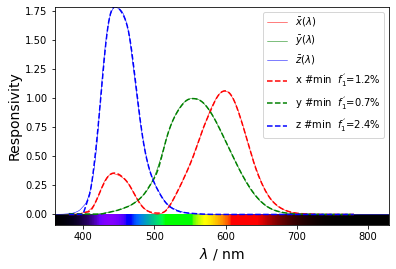

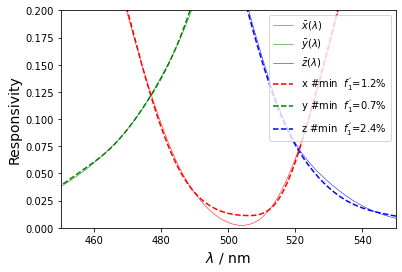

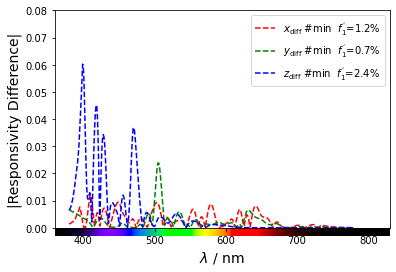

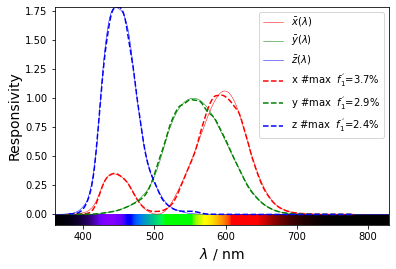

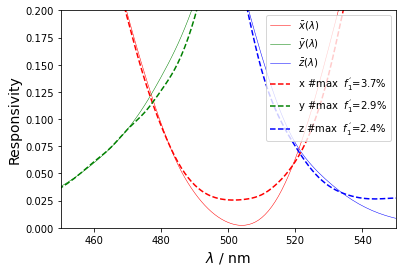

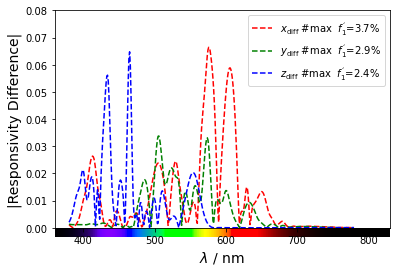

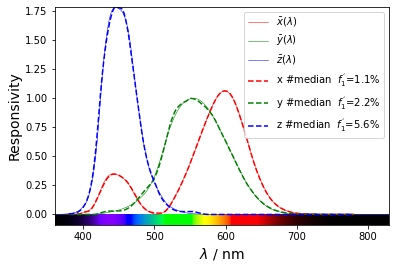

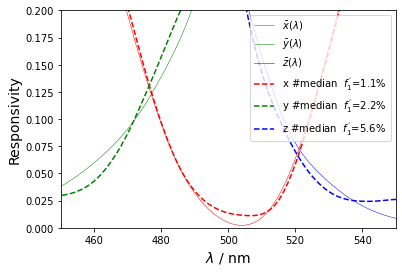

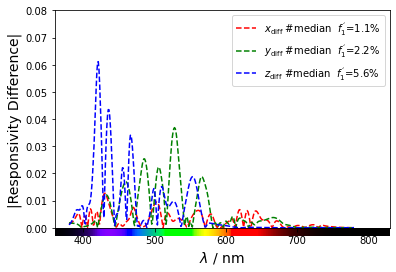

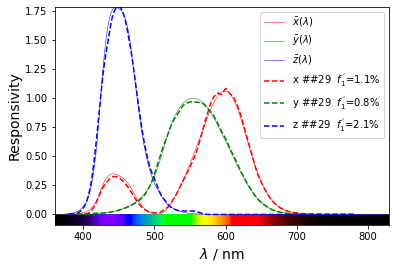

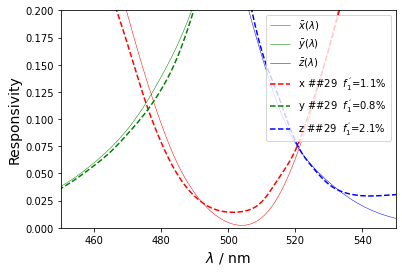

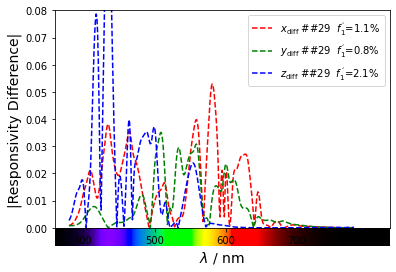

In [21]:
def out_detector_dir( det):
    out_detector = new_dir(out_dir, 'Det'+det)
    return out_detector

for i  in detList:
    out_detector = out_detector_dir( detector_name_list[i])
    plot_detector_cmf(i, cmf_detector_list[i], name=detector_name_list[i], out_dir = out_detector)
    plot_detector_cmf(i, cmf_detector_list[i], name=detector_name_list[i], xlim=[450,550], ylim=[0, 0.2], out_dir = out_detector)
    plot_detector_cmf_diff(i, cmf_detector_list[i], ylim=[0, 0.08], name=detector_name_list[i], out_dir = out_detector)

## calc the Yxy values of the detector from a given sepctrum (array) like spd_to_Yxy in luxpy

In [22]:
def spd_to_XYZ_detector( _cmf_detector, _data):
    dl = lx.getwld(_cmf_detector[0])
    XYZ_detector = (1.*(np.dot((_cmf_detector[1:]*dl),_data[1:].T)))[:,None,:]
    XYZ_detector = np.transpose(XYZ_detector,[1,2,0])
    XYZ_detector = np.squeeze(XYZ_detector, axis=0)
    return XYZ_detector

In [30]:
def xy_diff_plot(reference, Yxy, Yxy_detector, name_ext='', lines = True, ylim=None, xlim=None, detector = None, xlabel='$\lambda$ / nm', out_dir = None, ax = None, item = 0):
    # plot the xy differences form ideal data to the data generated by the detector
    if not ax:
        _, ax = pyplot.subplots()
    if lines:
        mark = marker
    else:
        mark = point_marker
    ax.plot(reference, Yxy_detector[1] - Yxy[1], mColor[0] +  mark[item], label=r'$x/y_{\mathrm{diff}}$ #'+ str(detector) + ' ' + name_ext)
    #ax.plot(reference, Yxy_detector[2] - Yxy[2], mColor[1] +  mark[item], label=r'$y_{\mathrm{diff}}$ #'+ str(detector) + ' ' + name_ext)
    # without additional label (to much text)
    ax.plot(reference, Yxy_detector[2] - Yxy[2], mColor[1] +  mark[item])
    ax.set_xlabel( xlabel, fontsize=label_font_size)
    ax.set_ylabel(r'$\Delta x, \Delta y$', fontsize=label_font_size)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
    ax.legend()
    if out_dir:
        save_fig(out_dir, 'xy_diff' + str(detector) + name_ext)
    return ax

def d_diff_plot(reference, Yxy, Yxy_detector, name_ext='', lines = True, ylim=None, xlim=None, spectrum_color=False,
                ax=None, item=0, detector = None, xlabel = '$\lambda$ / nm', out_dir = None):
    if not ax:
        _, ax = pyplot.subplots()
    d = np.sqrt((Yxy_detector[1] - Yxy[1])**2 + (Yxy_detector[2] - Yxy[2])**2)
    if lines:
        mark = marker
    else:
        mark = point_marker
    ax.plot(reference, d, mColor[item] +  mark[item], label=r'$d $#'+ str(detector) + name_ext)
    if spectrum_color:
        plot_spectrum_colors(spdmax=np.max(d) if not ylim else ylim[1], axh = ax, wavelength_height = -0.05, xlim = [np.min(reference), np.max(reference)] if not xlim else xlim)
    ax.set_xlabel( xlabel, fontsize=label_font_size)
    ax.set_ylabel(r'$d$', fontsize=label_font_size)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
    ax.legend()
    if out_dir:
        save_fig(out_dir, 'd_diff' + str(detector) + name_ext)
    return ax

def ldom_diff_plot(reference, Yxy, Yxy_detector, name_ext='', lines = True, ylim=None, xlim=None, spectrum_color=False,
                ax=None, item=0, detector = None, xlabel = '$\lambda_{\mathrm{dom}}$ / nm', ylabel = '$\Delta \lambda_{\mathrm{dom}}$ / nm', out_dir = None):
    if not ax:
        _, ax = pyplot.subplots()

    XYZ = lx.Yxy_to_xyz(Yxy.T).T
    lDom = lx.xyz_to_Ydlep(XYZ.T).T[1]
    XYZ_detector = lx.Yxy_to_xyz(Yxy_detector.T).T
    lDom_detector = lx.xyz_to_Ydlep(XYZ_detector.T).T[1]

    d = np.abs(lDom_detector) - np.abs(lDom)
    if lines:
        mark = marker
    else:
        mark = point_marker
    ax.plot(reference, d, mColor[item] +  mark[item], label=str(detector) + name_ext)
    if spectrum_color:
        plot_spectrum_colors(spdmax=np.max(d) if not ylim else ylim[1], axh = ax, wavelength_height = -0.05, xlim = [np.min(reference), np.max(reference)] if not xlim else xlim)
    ax.set_xlabel( xlabel, fontsize=label_font_size)
    ax.set_ylabel(ylabel, fontsize=label_font_size)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
    ax.legend()
    if out_dir:
        save_fig(out_dir, 'ldom_diff' + str(detector) + name_ext)
    return ax

def cct_diff_plot(reference, Yxy, Yxy_detector, name_ext='', lines = True, ylim=None, xlim=None, spectrum_color=False,
                ax=None, item=0, detector = None, xlabel = '$CCT$ / K', ylabel = '$\Delta CCT$ / K', out_dir = None):
    if not ax:
        _, ax = pyplot.subplots()

    XYZ = lx.Yxy_to_xyz(Yxy.T).T
    cct = lx.xyz_to_cct(XYZ.T).T[0]
    XYZ_detector = lx.Yxy_to_xyz(Yxy_detector.T).T
    cct_detector = lx.xyz_to_cct(XYZ_detector.T).T[0]

    d = np.abs(cct_detector) - np.abs(cct)
    if lines:
        mark = marker
    else:
        mark = point_marker
    ax.plot(reference, d, mColor[item] +  mark[item], label=str(detector) + name_ext)
    if spectrum_color:
        plot_spectrum_colors(spdmax=np.max(d) if not ylim else ylim[1], axh = ax, wavelength_height = -0.05, xlim = [np.min(reference), np.max(reference)] if not xlim else xlim)
    ax.set_xlabel( xlabel, fontsize=label_font_size)
    ax.set_ylabel(ylabel, fontsize=label_font_size)
    if ylim:
        ax.set_ylim(ylim)
    if xlim:
        ax.set_xlim(xlim)
    ax.legend()
    if out_dir:
        save_fig(out_dir, 'cct_diff' + str(detector) + name_ext)
    return ax


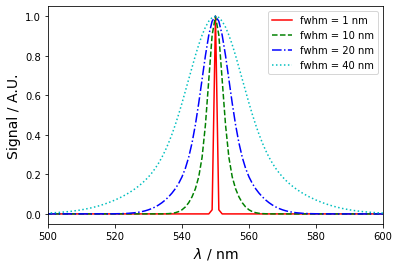

In [31]:
sd_model = mono_led_spd( 550, wl=wl_calc, fwhm=fwhm_list_model)
fig, ax = pyplot.subplots()
for i in range( len(fwhm_list_model)):
    ax.plot(sd_model[0], sd_model[i+1], mColor[i] + marker[i], label='fwhm = {0} nm'.format(fwhm_list_model[i]))
ax.set_xlim([500, 600])
ax.set_xlabel('$\lambda$ / nm', fontsize=label_font_size)
ax.set_ylabel('Signal / A.U.', fontsize=label_font_size)
ax.legend()
save_fig(out_dir, 'led_model')

In [32]:
def calc_LED_model(fwhm=20, plot_sd=None, out_dir = None):
    sd = mono_led_spd( wl_check, wl=wl_calc, fwhm=fwhm)
    # plot the spectral locus of the data
    Yxy=lx.xyz_to_Yxy(lx.spd_to_xyz(sd)).T

    if plot_sd:
        # plot selected SD from the dataset
        fig, ax = pyplot.subplots()
        for i in plot_sd:
            ax.plot(sd[0], sd[i], label='SD #{0} {1}{2} nm fwhm={3:.0f} nm'.format(i, r'$\lambda=$', wl_check[i],fwhm))
        if spectrum_color:
            plot_spectrum_colors(spdmax=1, axh = ax, wavelength_height = -0.05)
        ax.set_xlabel(strd['xlambda'], fontsize=label_font_size)
        ax.set_ylabel('spectral distribution / A.U.', fontsize=label_font_size)
        ax.legend()
        if out_dir:
            save_fig(out_dir, 'sd_{0:.0f}'.format( float(fwhm)))

    return sd, Yxy

def spectral_locus( Yxy_detector, det_name = None, out_dir = None, fwhm=42, ax = None, item = 0):
    if not ax:
        sd = mono_led_spd( wl_check, wl=wl_calc, fwhm=0.1)
        Yxy_locus=lx.xyz_to_Yxy(spd_to_xyz(sd)).T
        fig, ax = pyplot.subplots()
        ax.plot(Yxy_locus[1], Yxy_locus[2], label=cieobs)

    ax.plot(Yxy_detector[1], Yxy_detector[2], mColor[item] +  marker[item], label='Det. #{0}, fwhm={1:.0f} nm'.format(det_name, fwhm))
    ax.set_aspect('equal')
    ax.set_xlabel(r'x', fontsize=label_font_size)
    ax.set_ylabel(r'y', fontsize=label_font_size)
    ax.legend()
    if out_dir:
        save_fig(out_dir, 'spectral_locus_{0}_fwhm={1:.0f}_nm'.format(det_name, float(fwhm)))

    return ax


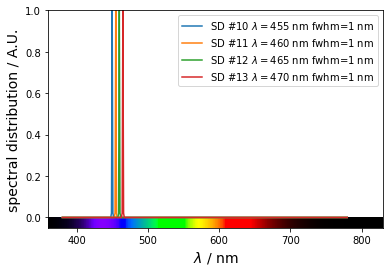

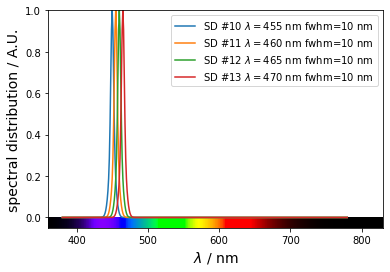

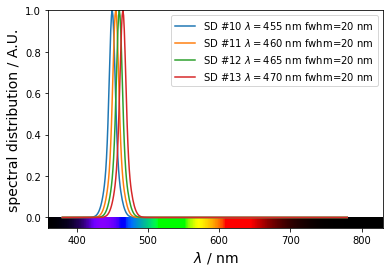

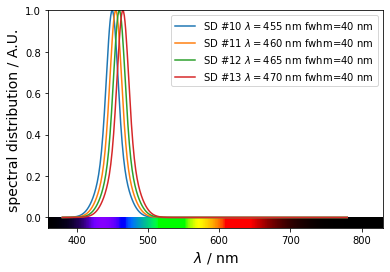

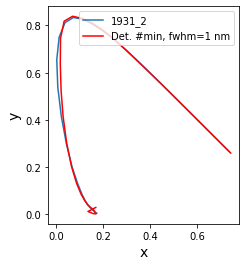

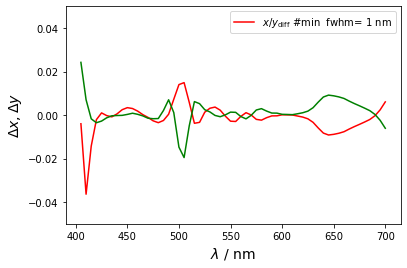

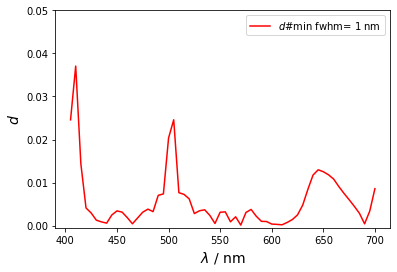

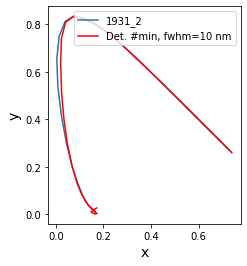

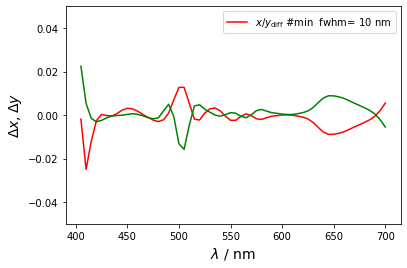

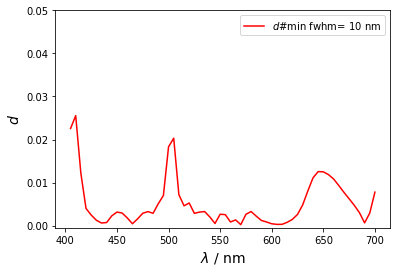

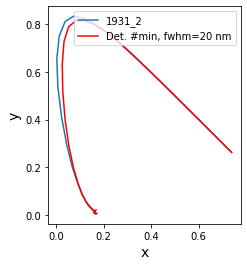

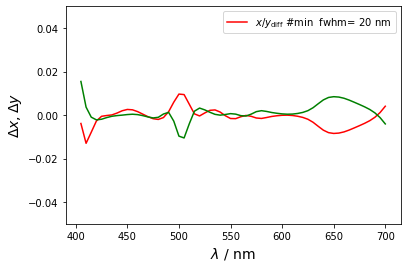

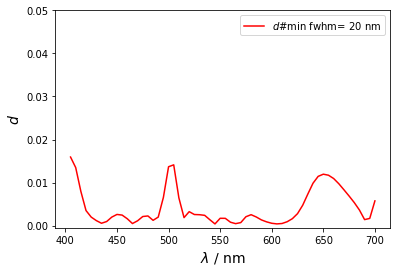

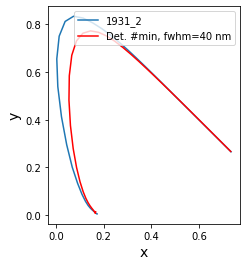

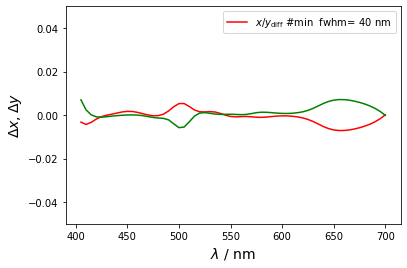

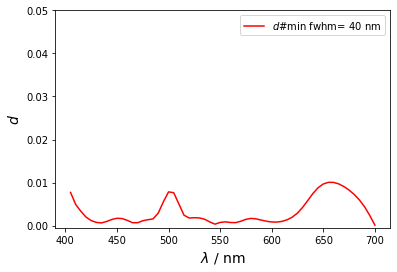

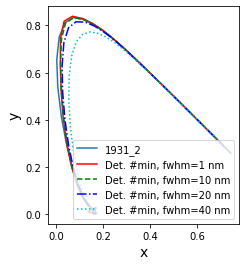

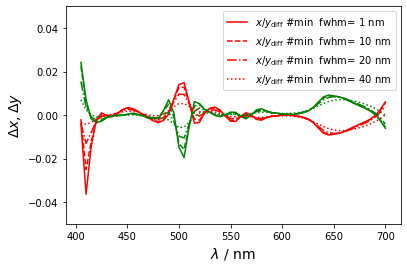

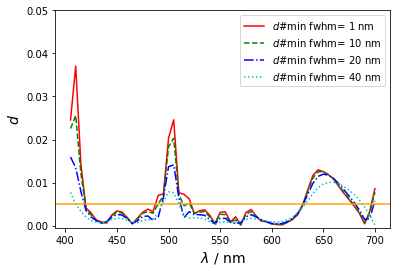

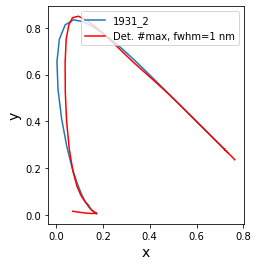

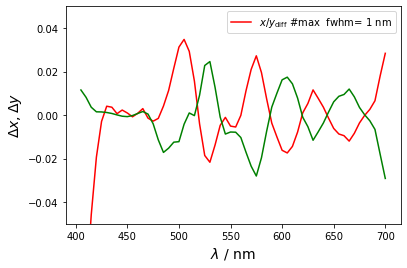

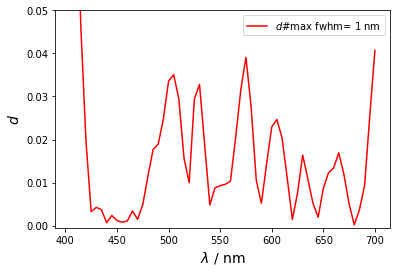

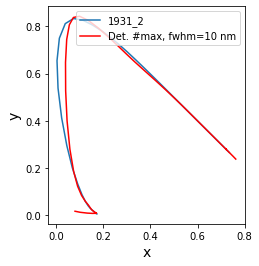

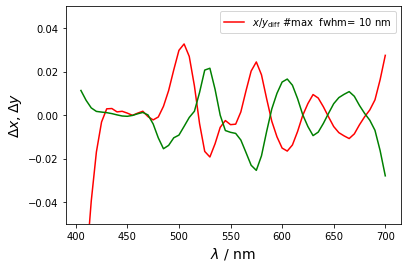

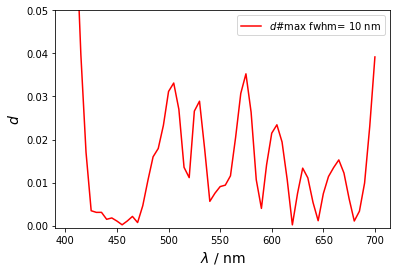

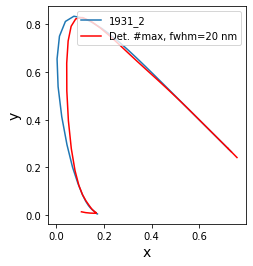

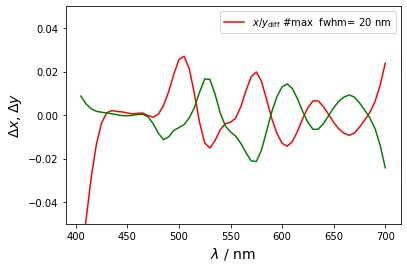

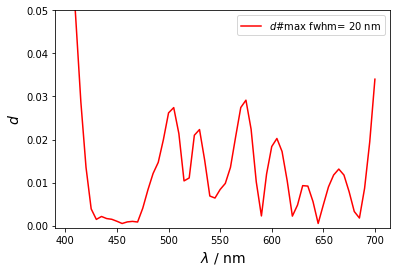

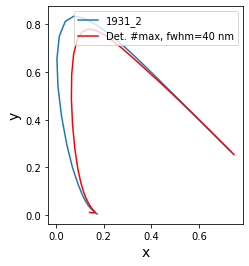

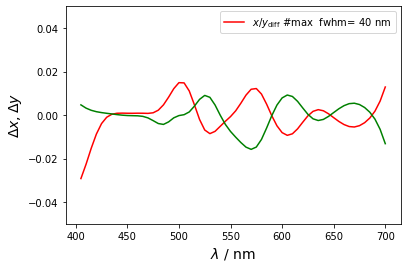

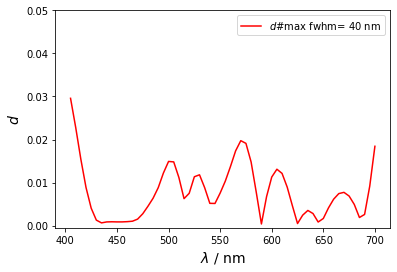

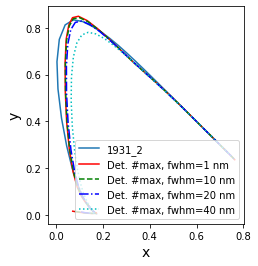

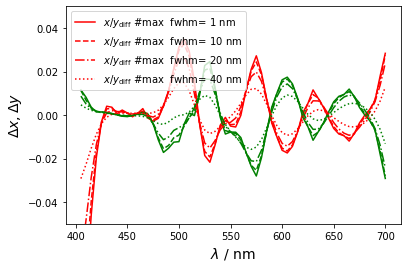

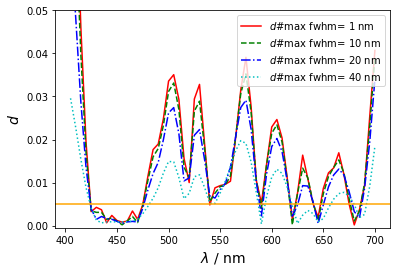

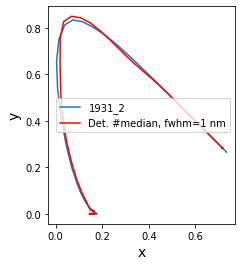

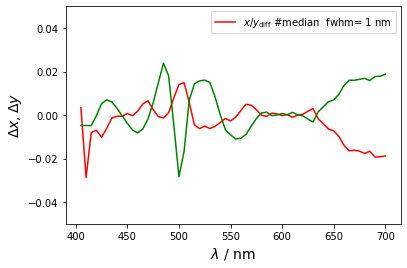

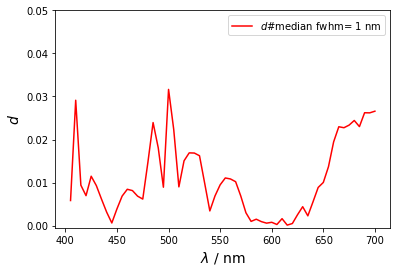

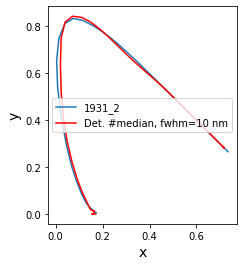

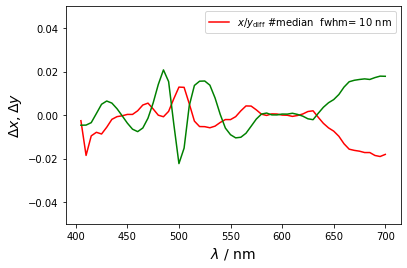

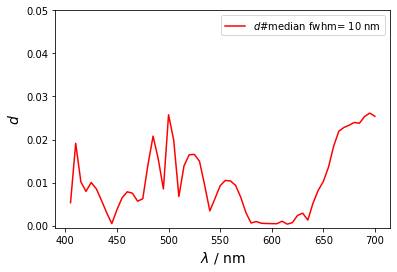

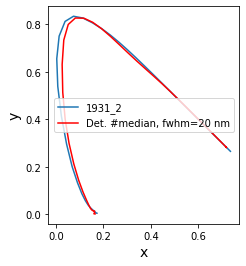

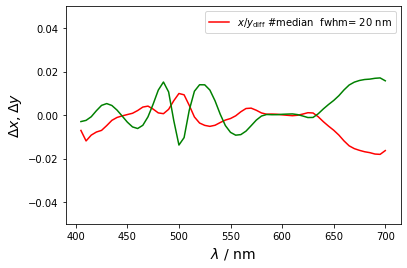

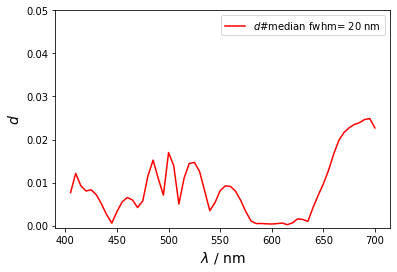

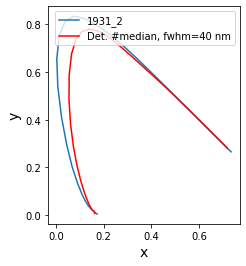

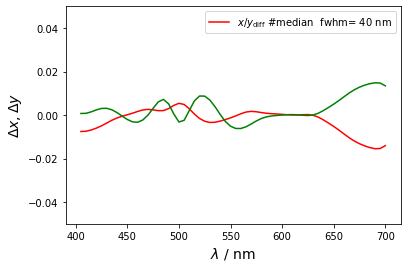

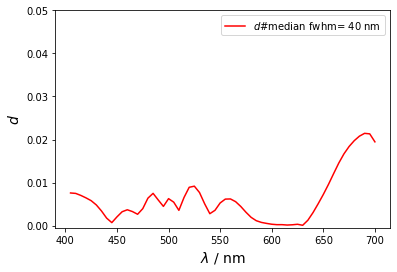

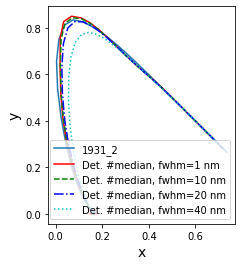

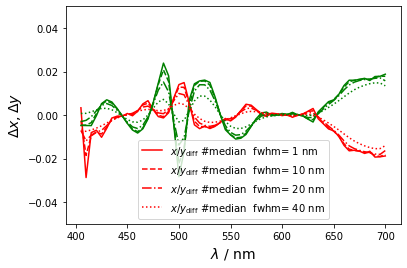

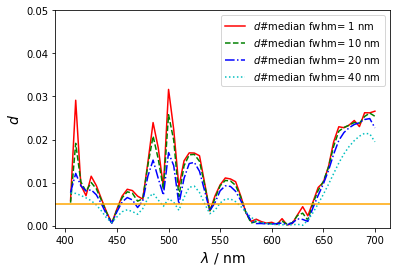

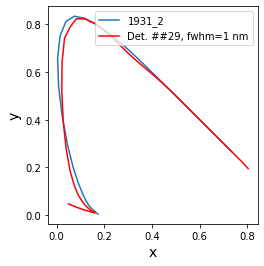

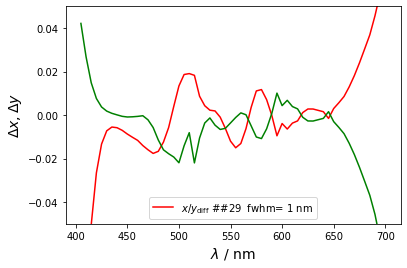

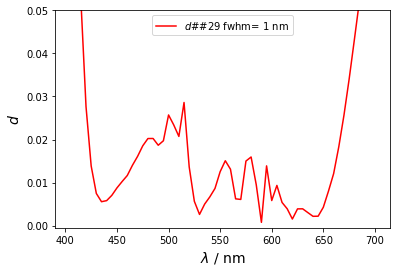

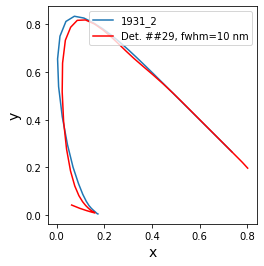

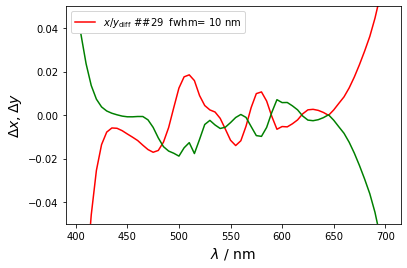

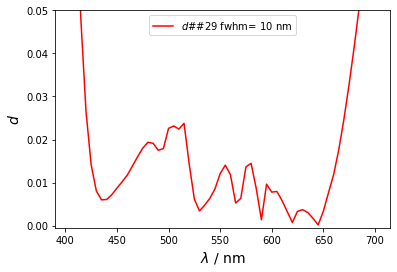

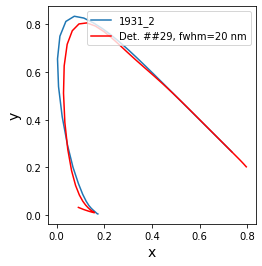

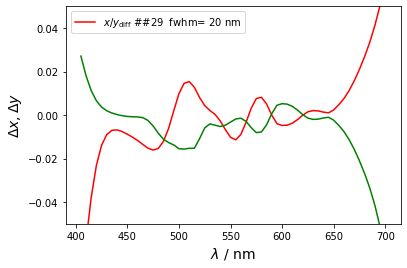

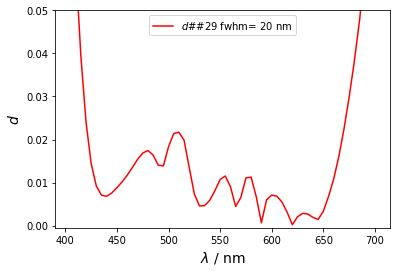

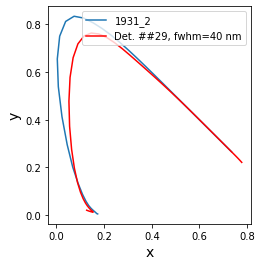

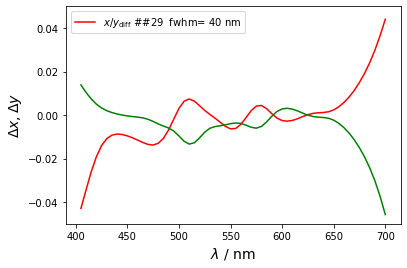

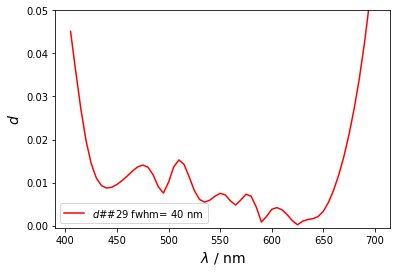

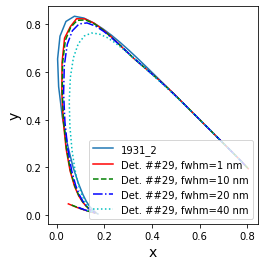

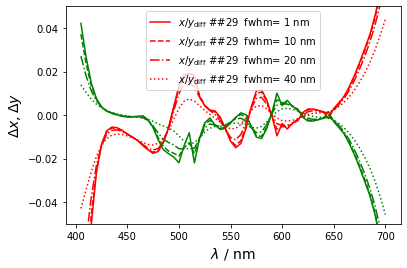

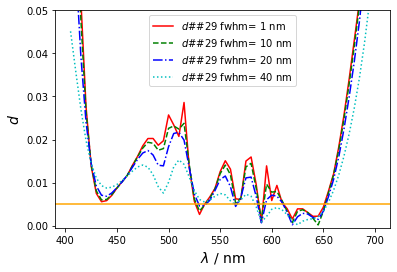

In [33]:
ddiff_limit = 0.05
# in relation to fwhm
sd_list = list()
Yxy_list = list()

# generate some artificial SDs
fwhm_list = [1., 10., 20., 40.]
#fwhm_list = [1., 20.]
for i, fwhm in enumerate(fwhm_list):
    sd, Yxy = calc_LED_model(plot_sd=[10,11,12,13], fwhm=fwhm, out_dir=new_dir(out_dir, 'sd'))
    sd_list.append(sd)
    Yxy_list.append(Yxy)

Yxy_detector_list = list()
for i_det, det  in enumerate(detList):
    out_detector = out_detector_dir(detector_name_list[det])
    # in relation to the detector to be evaluated
    Yxy_detector_list.append( list())
    # evaluate the detector for different fwhm models
    for i, fwhm in enumerate(fwhm_list):
        Yxy_detector_list[i_det].append( lx.xyz_to_Yxy(spd_to_XYZ_detector(cmf_detector_list[det], sd_list[i])).T)
        spectral_locus( Yxy_detector_list[i_det][i], det_name = detector_name_list[det], out_dir = out_detector, fwhm=fwhm)
        xy_diff_plot(wl_check, Yxy_list[i], Yxy_detector_list[i_det][i], name_ext=' fwhm= {0:.0f} nm'.format(fwhm), detector=detector_name_list[det], ylim=[-ddiff_limit, ddiff_limit], out_dir=out_detector)
        d_diff_plot(wl_check, Yxy_list[i], Yxy_detector_list[i_det][i], name_ext=' fwhm= {0:.0f} nm'.format(fwhm), spectrum_color=False, detector=detector_name_list[det], ylim=[-0.0005,ddiff_limit], out_dir=out_detector)

    # summarize some of the graphs
    ax = None
    for j, fwhm in enumerate(fwhm_list):
        ax = spectral_locus( Yxy_detector_list[i_det][j], det_name = detector_name_list[det], fwhm=fwhm, item=j, ax=ax)
    ax.legend(loc='lower right')
    save_fig(out_detector, 'spectral_locus' + detector_name_list[det] + '_all')

    ax = None
    for j, fwhm in enumerate(fwhm_list):
        ax = xy_diff_plot(wl_check, Yxy_list[j], Yxy_detector_list[i_det][j], name_ext=' fwhm= {0:.0f} nm'.format(fwhm_list[j]),
                          detector=detector_name_list[det], ylim=[-ddiff_limit, ddiff_limit], ax=ax, item = j)
    save_fig(out_detector, 'xy_diff_{0}'.format(detector_name_list[det]))

    ax = None
    for j, fwhm in enumerate(fwhm_list):
        ax = d_diff_plot(wl_check, Yxy_list[j], Yxy_detector_list[i_det][j], name_ext=' fwhm= {0:.0f} nm'.format(fwhm_list[j]),
                          detector=detector_name_list[det],  ylim=[-0.0005,ddiff_limit], ax=ax, item = j)
    pyplot.axhline(y = dtolerance, color ="orange", linestyle ="-")
    save_fig(out_detector, 's_diff_{0}'.format(detector_name_list[det]))


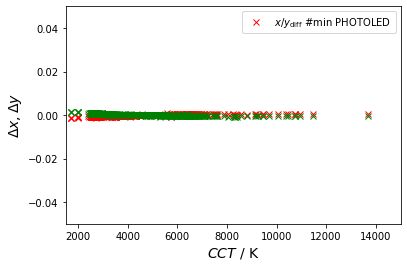

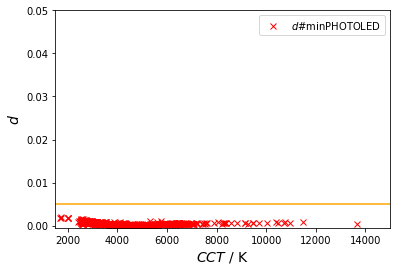

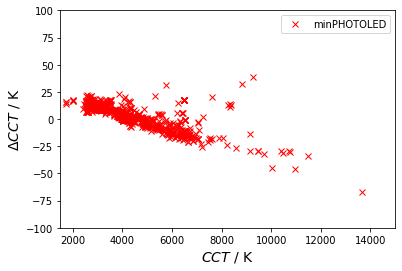

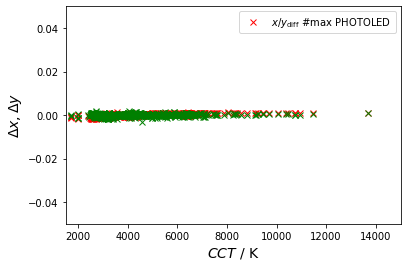

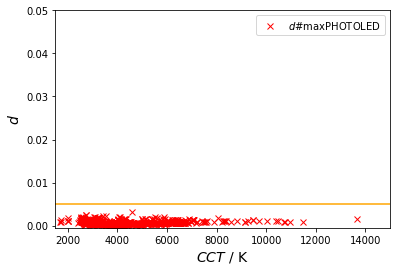

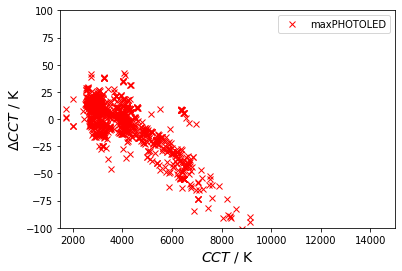

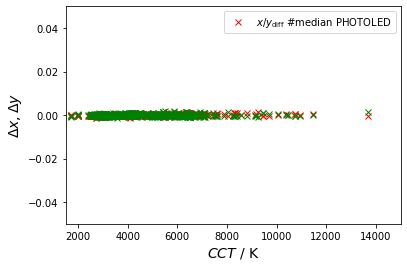

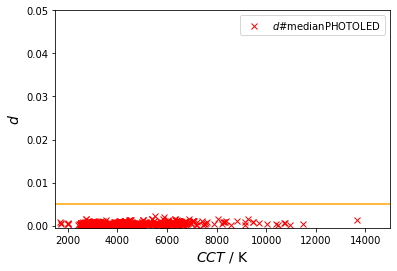

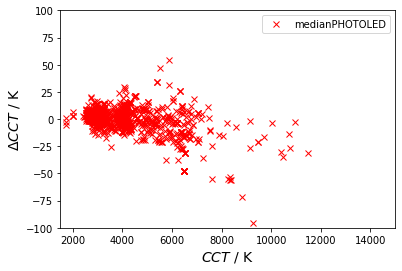

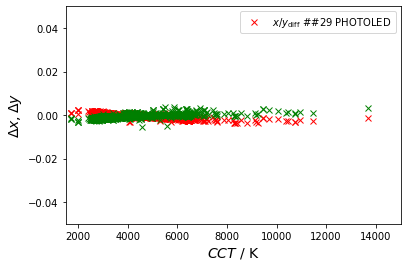

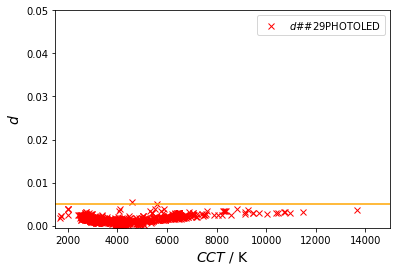

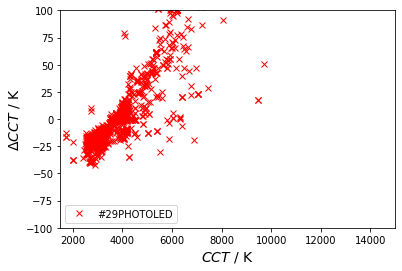

In [37]:
b_use_mono = False
if b_use_mono:
    dataSet = 'MONOLED'
else:
    dataSet = 'PHOTOLED'

sd_org = _SPD[dataSet]['S']['data'].copy()
sd = lx.cie_interp(sd_org, wl_new=wl_calc, kind='S')
XYZ = lx.spd_to_xyz(sd)
Yxy=lx.xyz_to_Yxy(XYZ).T
if b_use_mono:
    reference = lx.xyz_to_Ydlep(XYZ).T[1]
    xlim=[wl_check[0], wl_check[-1]]
    xlabel = '$\lambda_{\mathrm{dom}}$ / nm'
else:
    reference = lx.xyz_to_cct(XYZ).T[0]
    xlim=[1500, 15000]
    xlabel='$CCT$ / K'

for i_det, det  in enumerate(detList):
    cmf_detector = cmf_detector_list[det]
    out_detector = out_detector_dir(detector_name_list[det])

    XYZ_detector = spd_to_XYZ_detector(cmf_detector, sd).T
    Yxy_detector=lx.xyz_to_Yxy(XYZ_detector.T).T

    xy_diff_plot(reference, Yxy, Yxy_detector, name_ext=dataSet, lines=False, ylim=[-ddiff_limit, ddiff_limit], xlim=xlim, detector=detector_name_list[det], xlabel=xlabel)
    save_fig(out_detector, dataSet + 'xy_diff' + detector_name_list[det])

    ax1 = d_diff_plot(reference, Yxy, Yxy_detector, name_ext=dataSet, lines=False,
                    ylim=[-0.0005, ddiff_limit], xlim=xlim, spectrum_color=False, detector=detector_name_list[det], xlabel=xlabel)
    if b_use_mono:
        i_compare = fwhm_list.index(20)
        d_diff_plot(wl_check, Yxy_list[i_compare], Yxy_detector_list[i_det][i_compare], 'fwhm' + str(fwhm_list[i_compare]) + ' nm',
                    ax=ax1, item=1, detector=detector_name_list[det], xlabel=xlabel)
    pyplot.axhline(y = dtolerance, color ="orange", linestyle ="-")
    save_fig(out_detector, dataSet + 'd_diff' + detector_name_list[det])

    if b_use_mono:
        ax1 = ldom_diff_plot(reference, Yxy, Yxy_detector, name_ext=dataSet, lines=False,
                        ylim=[-10, 10], xlim=xlim, spectrum_color=False, detector=detector_name_list[det], xlabel=xlabel, ylabel='$\Delta \lambda_{\mathrm{dom}}$ / nm')
        ldom_diff_plot(wl_check, Yxy_list[i_compare], Yxy_detector_list[i_det][i_compare], 'fwhm' + str(fwhm_list[i_compare]) + ' nm',
                    ax=ax1, item=1, detector=detector_name_list[det], xlabel=xlabel)
        save_fig(out_detector, dataSet + 'dldom_diff' + detector_name_list[det])
    else:
        ax1 = cct_diff_plot(reference, Yxy, Yxy_detector, name_ext=dataSet, lines=False,
                        ylim=[-100, 100], xlim=xlim, spectrum_color=False, detector=detector_name_list[det], xlabel=xlabel, ylabel='$\Delta CCT$ / K')
        save_fig(out_detector, dataSet + 'dCCT_diff' + detector_name_list[det])



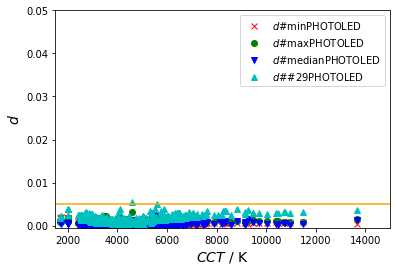

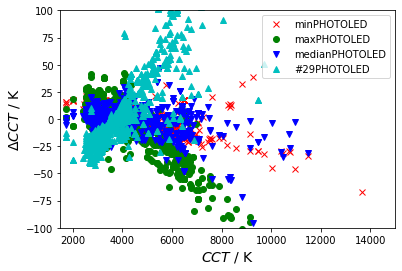

In [38]:
ax = None
for i_det, det  in enumerate(detList):
    cmf_detector = cmf_detector_list[det]
    Yxy_detector=lx.xyz_to_Yxy(spd_to_XYZ_detector(cmf_detector, sd)).T
    ax = d_diff_plot(reference, Yxy, Yxy_detector, name_ext=dataSet, lines=False,
                    ylim=[-0.0005, ddiff_limit], xlim=xlim, spectrum_color=False, detector=detector_name_list[det], xlabel=xlabel, ax=ax, item=i_det%len(marker))
if len(detList) > 5:
    ax.legend().remove()
pyplot.axhline(y = dtolerance, color ="orange", linestyle ="-")
save_fig(out_dir, dataSet + 'd_diff' + 'compare')

dldom_list = list()
ax = None
if b_use_mono:
    for i_det, det  in enumerate(detList):
        cmf_detector = cmf_detector_list[det]
        XYZ_detector = spd_to_XYZ_detector(cmf_detector, sd).T
        Yxy_detector=lx.xyz_to_Yxy(XYZ_detector.T).T
        lDom_detector = lx.xyz_to_Ydlep(XYZ_detector.T).T[1]
        dldom_list.append(np.abs(lDom_detector)-np.abs(reference))
        ax = ldom_diff_plot(reference, Yxy, Yxy_detector, name_ext=dataSet, lines=False,
                        ylim=[-10, 10], xlim=xlim, spectrum_color=False, detector=detector_name_list[det], xlabel=xlabel, ax=ax, item=i_det%len(marker))
    if len(detList) > 5:
        ax.legend().remove()
    save_fig(out_dir, dataSet + 'dldom_diff' + 'compare')
else:
    for i_det, det  in enumerate(detList):
        cmf_detector = cmf_detector_list[det]
        Yxy_detector=lx.xyz_to_Yxy(spd_to_XYZ_detector(cmf_detector, sd)).T
        ax = cct_diff_plot(reference, Yxy, Yxy_detector, name_ext=dataSet, lines=False,
                        ylim=[-100, 100], xlim=xlim, spectrum_color=False, detector=detector_name_list[det], xlabel=xlabel, ax=ax, item=i_det%len(marker))
    if len(detList) > 5:
        ax.legend().remove()
    save_fig(out_dir, dataSet + 'dcct_diff' + 'compare')


In [36]:
#fig = pyplot.figure()
#ax = fig.add_subplot(projection='3d')
#detector_number = [i for i in range( len(detList))]
#xsize = reference.shape[0]
#ysize = len( detList)
#zsize = len(dldom_list[0])
#
#xdata = np.zeros((xsize, ysize, zsize))
#ydata = np.zeros_like(xdata)
#zdata = np.zeros_like(xdata)
#
#for i in range(ysize):
#    for j in range(zsize):
#        xdata[:,i,j] = reference
#for i in range(xsize):
#    for j in range(ysize):
#        ydata[i,j,:] = dldom_list[j]
#for i in range(xsize):
#    for j in range(zsize):
#        zdata[i,:,j] = detList
#ax.scatter(xdata, ydata, zdata)